In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%pylab inline

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.style.use('science')
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys; sys.path.insert(0, "../")
import sys; sys.path.insert(0, "../inverse_parametric_burgers/")

import numpy as np
from utils import *
from models import RobustPCANN
from parametric_discovery_pinn import ParametricPINN, FinalParametricPINN
from madgrad import MADGRAD

from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from robust_pde_diff import print_pde, RobustPCA, Robust_LRSTR, DLrSR
from parametric_pde_diff import TrainSGTRidge, create_groups
from pytorch_robust_pca import R_pca

from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time

from pysr import pysr, best

fontsize = 20

Populating the interactive namespace from numpy and matplotlib
Running Python 3.9.8
You can use npar for np.array


In [2]:
data = pickle_load("../parametric_pde_data/parametric_advection_diffusion.pkl")

x = data['x']; spatial_dims = x.shape[0]
t = data['t']; time_dims = t.shape[0]
Exact = data['u']

X, T = np.meshgrid(x, t)

# Adding noise
noise_intensity = 0.01
NOISELESS_MODE = False
if NOISELESS_MODE: print("Denoising off")
else: print("Denoising on")
noisy_xt = False; noisy_labels = False; mode = int(noisy_xt)+int(noisy_labels)

X_star = np.hstack((to_column_vector(X), to_column_vector(T)))
u_star = to_column_vector(Exact.T)

# domain bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

# Sampling training data points
N = 25000
training_idxs = sampling_from_rows(X_star, N, True)
X_train = X_star[training_idxs, :]
u_train = u_star[training_idxs, :]

# Add noise to (x, t) before setting the lb, and ub.
if noisy_xt: 
    print("Noisy (x, t)")
    X_train = perturb(X_train, intensity=noise_intensity, noise_type="normal")
else: print("Clean (x, t)")
if noisy_labels:
    print("Noisy labels")
    u_train = perturb(u_train, intensity=noise_intensity, noise_type="normal")
else: print("Clean labels")

# to_tensor
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)
X_train = to_tensor(X_train, True)
u_train = to_tensor(u_train, False)
lb = to_tensor(lb, False)
ub = to_tensor(ub, False)

L = 5
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(spatial_dims)

eq_name = "ad"

Loaded from ../parametric_pde_data/parametric_advection_diffusion.pkl
Denoising on
Clean (x, t)
Clean labels


In [3]:
x, t = dimension_slicing(X_train)

In [4]:
# Clean all: (1.2523253 * sin(-1.2530949*x)) | cos(1.2594514*x)−1.5031303
# Noisy1: (1.2536734 * sin(-1.252591*x)) | cos(1.2590762*x)−1.5028094
# Noisy2: (1.2010298 * sin(-1.2499514*x)) | cos(1.2681643*x)−1.4841684

In [5]:
pinn = ParametricPINN(n_funcs=3, scale=True, lb=lb, ub=ub, eq_name=eq_name)
pinn = load_weights(pinn, "./saved_path_inverse_parametric_ad/parametric_pinn_with_fg.pth")
model = nn.Sequential(pinn.preprocessor_net, pinn.pde_solver_net)

pde_terms = ["u", "u_x", "u_xx"]

if mode == 0 or mode > 2: 
    func_terms = ["-1.2523253*sin(1.2530949*x)", "cos(1.2594514*x)-1.5031303", "0.09376708"]
    name = "cleanall"
elif mode == 1: 
    func_terms = ["-1.2536734*sin(1.2536734*x)", "cos(1.2608153*x)-1.5014627", "0.09376708"]
    name = "noisy1"
elif mode == 2: 
    func_terms = ["-1.2010298*sin(1.2010298*x)", "cos(1.2608153*x)-1.5014627", "0.09376708"]
    name = "noisy2"

final_ad_pinn = FinalParametricPINN(model=model, pde_terms=pde_terms, 
                                        func_terms=func_terms, uncert=True, 
                                        scale=pinn.scale, lb=pinn.lb, ub=pinn.ub, 
                                        trainable_one=True
                                       )
del pinn

Loaded the model's weights properly


In [6]:
for i in range(3): print(see_params(final_ad_pinn.pdc.funcs[i]))

[tensor(-1.2523), tensor(1.2531)]
[tensor(-1.5031), tensor(1.2595)]
[tensor(0.0938)]


In [7]:
_, x_fft, x_PSD = fft1d_denoise(X_train[:, 0:1], c=-5, return_real=True)
_, t_fft, t_PSD = fft1d_denoise(X_train[:, 1:2], c=-5, return_real=True)
_, u_train_fft, u_train_PSD = fft1d_denoise(u_train, c=-5, return_real=True)
x_fft, x_PSD = x_fft.detach(), x_PSD.detach()
t_fft, t_PSD = t_fft.detach(), t_PSD.detach()

In [8]:
### New implementation ###
class RobustFinalParametricPINN(nn.Module):
    def __init__(self, pinn, init_cs=(0.1, 0.1), init_betas=(0.0, 0.0), noiseless_mode=True):
        super(RobustFinalParametricPINN, self).__init__()
        self.pinn = pinn
        self.noiseless_mode = noiseless_mode
        self.in_fft_nn = None; self.out_fft_nn = None
        self.inp_rpca = None; self.out_rpca = None
        if not self.noiseless_mode:
            # FFTNN
            self.in_fft_nn = FFTTh(c=init_cs[0])
            self.out_fft_nn = FFTTh(c=init_cs[1])

            # Robust Beta-PCA
            self.inp_rpca = RobustPCANN(beta=init_betas[0], is_beta_trainable=True, inp_dims=2, hidden_dims=32)
            self.out_rpca = RobustPCANN(beta=init_betas[1], is_beta_trainable=True, inp_dims=1, hidden_dims=32)

    def forward(self, x, t):
        return self.pinn(x, t)

    def loss(self, X_input, X_input_noise, y_input, y_input_noise):
        if not self.noiseless_mode:
            # (1) Denoising FFT on (x, t)
            # This line returns the approx. recon.
            X_input_noise = cat(torch.fft.ifft(self.in_fft_nn(X_input_noise[1])*X_input_noise[0]).real.reshape(-1, 1), 
                                torch.fft.ifft(self.in_fft_nn(X_input_noise[3])*X_input_noise[2]).real.reshape(-1, 1))
            X_input_noise = X_input-X_input_noise
            X_input = self.inp_rpca(X_input, X_input_noise, normalize=True)
            
            # (2) Denoising FFT on y_input
            y_input_noise = y_input-torch.fft.ifft(self.out_fft_nn(y_input_noise[1])*y_input_noise[0]).real.reshape(-1, 1)
            y_input = self.out_rpca(y_input, y_input_noise, normalize=True)
            
        return self.pinn.loss(X_input[:, 0:1], X_input[:, 1:2], y_input)

In [9]:
robust_ad_pinn = RobustFinalParametricPINN(pinn=final_ad_pinn, noiseless_mode=NOISELESS_MODE)

In [10]:
def pcgrad_closure(return_list=False):
    global N, x, t, u_train
    losses = robust_ad_pinn.loss(X_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD))
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in final_ad_pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(final_ad_pinn.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return losses[0]+losses[1]
    else: return losses

In [11]:
def finetuning_closure():
    global N, x, t, u_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    mse_loss, pde_loss = robust_ad_pinn.loss(X_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD))
    loss = mse_loss + pde_loss
    if loss.requires_grad: loss.backward(retain_graph=False)
    return loss

In [12]:
# optimizer = MADGRAD(robust_ad_pinn.parameters(), lr=1e-6, momentum=0.9)
# for i in range(150):
#     final_ad_pinn.train()
#     optimizer.step(pcgrad_closure)
#     if i%10==0: print(pcgrad_closure(return_list=True))
        
# f_opt = torch.optim.LBFGS(robust_ad_pinn.parameters(), lr=1e-1, max_iter=500, max_eval=int(1.25*500), history_size=300, line_search_fn='strong_wolfe')
# # final_ad_pinn.is_uncert = False
# for i in range(50):
#     f_opt.step(finetuning_closure)
#     if i%10==0: print(finetuning_closure())

In [13]:
if mode == 0: weights_path = "./saved_path_inverse_parametric_ad/cleanall_final_finetuned_robust_pinn.pth"
if mode == 1: weights_path = "./saved_path_inverse_parametric_ad/noisy1_final_finetuned_robust_pinn.pth"
if mode == 2: weights_path = "./saved_path_inverse_parametric_ad/noisy2_final_finetuned_robust_pinn.pth"
robust_ad_pinn = load_weights(robust_ad_pinn, weights_path)

Loaded the model's weights properly


In [14]:
F.mse_loss(robust_ad_pinn(X_star[:, 0:1], X_star[:, 1:2]), u_star).item()

2.2811040878423228e-07

In [15]:
u_pred = robust_ad_pinn(X_star[:, 0:1], X_star[:, 1:2]).detach().numpy()
print(relative_l2_error(u_pred, u_star.detach().numpy()))
u_pred = u_pred.reshape(X.shape)

0.0010589083


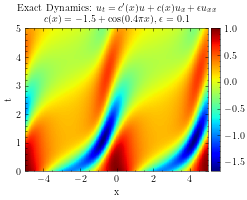

In [16]:
fig, ax = plt.subplots(1, 1)

h = ax.imshow(Exact.T, interpolation='nearest', cmap='jet', 
          extent=[lb[0], ub[0], lb[1], ub[1]], 
          origin='lower', aspect='auto')

ax.set_title("Exact Dynamics: $u_{t} = c^{\prime}(x)u+c(x)u_{x}+\epsilon u_{xx}$\n $c(x)=-1.5+\cos(0.4\pi x)$, $\epsilon = 0.1$", fontsize = 10)
ax.set_xlabel('x')
ax.set_ylabel('t')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

fig.savefig(f"./vis_pics/Exact_Dynamics.png", dpi=300)
plt.show()

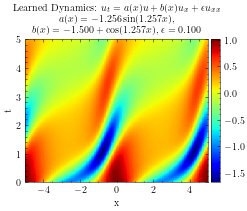

In [17]:
fig, ax = plt.subplots(1, 1)

h = ax.imshow(u_pred, interpolation='nearest', cmap='jet', 
          extent=[lb[0], ub[0], lb[1], ub[1]], 
          origin='lower', aspect='auto')

# ax.set_title("Exact Dynamics: $u_{t} = c^{\prime}(x)u+c(x)u_{x}+\epsilon u_{xx}$\n $c(x)=-1.5+\cos(0.4\pi x)$, $\epsilon = 0.1$", fontsize = 10)
if mode == 0: ax.set_title("Learned Dynamics: $u_{t} = a(x)u+b(x)u_{x}+\epsilon u_{xx}$\n $a(x)=-1.256\sin(1.257x)$,\n $b(x)=-1.500+\cos(1.257 x)$, $\epsilon = 0.100$", fontsize = 10)
if mode == 1: ax.set_title("Learned Dynamics: $u_{t} = a(x)u+b(x)u_{x}+\epsilon u_{xx}$\n $a(x)=-1.257\sin(1.257x)$,\n $b(x)=-1.500+\cos(1.257 x)$, $\epsilon = 0.100$", fontsize = 10)
if mode == 2: ax.set_title("Learned Dynamics: $u_{t} = a(x)u+b(x)u_{x}+\epsilon u_{xx}$\n $a(x)=-1.256\sin(1.258x)$,\n $b(x)=-1.499+\cos(1.256 x)$, $\epsilon = 0.100$", fontsize = 10)
ax.set_xlabel('x')
ax.set_ylabel('t')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

fig.savefig(f"./vis_pics/Learned_Dynamics_{name}.png", dpi=300)
plt.show()

In [18]:
# w/ DFT
# Clean all
# array([-1.25622261,  1.25651634, -1.49988151,  1.25663877,  0.09995594])
# (0.018936938168554983, 0.01667836126337147)
# Noisy1 | relative l2 error = 0.001746914
# array([-1.25678468,  1.25660324, -1.49969542,  1.2565794 ,  0.10003757])
# (0.015379903264666196, 0.012705832108171925)
# Noisy2
# array([-1.2556591 ,  1.2577163 , -1.49899721,  1.25608265,  0.10037906])
# (0.13074689872742037, 0.12494693424397522)

In [19]:
# ax.set_title("Learned Dynamics $u_{t} = a(x)u+b(x)u_{x}+\epsilon u_{xx}$\n $a(x)=-1.256+\sin(1.257x)$, $b(x)=-1.500+\cos(1.257 x)$, $\epsilon = 0.100$", fontsize = 10)
# ax.set_title("Learned Dynamics $u_{t} = a(x)u+b(x)u_{x}+\epsilon u_{xx}$\n $a(x)=-1.257+\sin(1.257x)$, $b(x)=-1.500+\cos(1.257 x)$, $\epsilon = 0.100$", fontsize = 10)
# ax.set_title("Learned Dynamics $u_{t} = a(x)u+b(x)u_{x}+\epsilon u_{xx}$\n $a(x)=-1.256+\sin(1.258x)$, $b(x)=-1.499+\cos(1.256 x)$, $\epsilon = 0.100$", fontsize = 10)

In [20]:
for i in range(3): print(see_params(final_ad_pinn.pdc.funcs[i]))

[tensor(-1.2564), tensor(1.2565)]
[tensor(-1.4998), tensor(1.2566)]
[tensor(0.1000)]


In [21]:
cc = 2.0*np.pi/5.0

In [22]:
preds = npar([x.item() for x in final_ad_pinn.pdc.funcs.parameters()])
grounds = npar([-cc, cc, -1.5, cc, 0.1])
preds

array([-1.25635958,  1.2565304 , -1.49984944,  1.25664961,  0.0999872 ])

In [23]:
errs = 100*(np.abs(preds-grounds)/np.abs(grounds))
errs.mean(), errs.std()

(0.010880779787934478, 0.006829722230739345)

In [24]:
# New results
# w/o DFT
# Clean all
# array([-1.25623655,  1.25656128, -1.49985731,  1.25665808,  0.09997236])
# (0.015345486828358346, 0.012099642990359417)
# Noisy1
# array([-1.25596786,  1.25678086, -1.49993205,  1.25670695,  0.09998032])
# (0.018892862741893963, 0.018004370233254713)
# Noisy2
# array([-1.25149083,  1.25566435, -1.49853253,  1.25527477,  0.10061844])
# (0.26232110489992866, 0.21606809907599014)

# w/ DFT
# Clean all
# V1
# array([-1.25622261,  1.25651634, -1.49988151,  1.25663877,  0.09995594])
# (0.018936938168554983, 0.01667836126337147)
# V2, Use this one. | relative l2 error  = 0.0010589083
# array([-1.25635958,  1.2565304 , -1.49984944,  1.25664961,  0.0999872 ])
# (0.010880779787934478, 0.006829722230739345)
# Noisy1 | relative l2 error = 0.001746914
# array([-1.25678468,  1.25660324, -1.49969542,  1.2565794 ,  0.10003757])
# (0.015379903264666196, 0.012705832108171925)
# Noisy2 | relative l2 error = 0.0067189233
# array([-1.2556591 ,  1.2577163 , -1.49899721,  1.25608265,  0.10037906])
# (0.13074689872742037, 0.12494693424397522)

In [25]:
# mean, std
# (0.04264339677138114, 0.0523326488183105)